In [1]:
# !pip install --upgrade datasets
# !pip install huggingface_hub
# !pip install matplotlib

In [2]:
 from datasets import load_dataset
 emotions = load_dataset("emotion")

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

 we see it is similar to a Python dictionary, with each key corresponding to a different
 split. And we can use the usual dictionary syntax to access an individual split

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
 len(train_ds)

16000

In [6]:
 train_ds[0]


{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
 train_ds.column_names


['text', 'label']

 and the values are the tweet and the emotion. This reflects the fact that  Datasets is
 based on Apache Arrow, which defines a typed columnar format that is more memory
 efficient than native Python. 
 
 We can see what data types are being used under the
 hood by accessing the features attribute of a Dataset object:

In [8]:
 print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


 In this case, the data type of the text column is string, while the label column is a
 special ClassLabel object that contains information about the class names and their
 mapping to integers. We can also access several rows with a slice

In [9]:
 print(train_ds[:5])


{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


 Note that in this case, the dictionary values are now lists instead of individual elements. 

We can also get the full column by name:

In [10]:
 print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


# From Datasets to DataFrames

In [11]:
 import pandas as pd
 emotions.set_format(type="pandas")
 df = emotions["train"][:]
 df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


the labels are represented as integers, so let’s
 use the int2str() method of the label feature to create a new column in our
 DataFrame with the corresponding label names

In [12]:
 def label_int2str(row):
     return emotions["train"].features["label"].int2str(row)

     
 df["label_name"] = df["label"].apply(label_int2str)
 df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Looking at the Class Distribution


 Whenever you are working on text classification problems, it is a good idea to exam
ine the distribution of examples across the classes. A dataset with a skewed class dis
tribution might require a different treatment in terms of the training loss and
 evaluation metrics than a balanced one

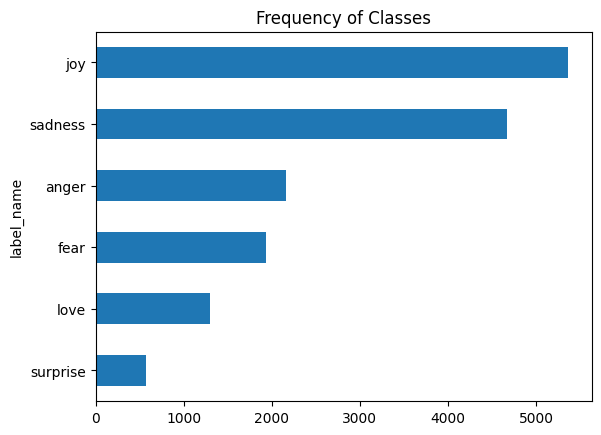

In [13]:
 import matplotlib.pyplot as plt

 df["label_name"].value_counts(ascending=True).plot.barh()
 plt.title("Frequency of Classes")
 plt.show()

 In this case, we can see that the dataset is heavily imbalanced; the joy and sadness
 classes appear frequently, whereas love and surprise are about 5–10 times rarer.
 There are several ways to deal with imbalanced data, including:

 • Randomly oversample the minority class.
 
 • Randomly undersample the majority class.
 
 • Gather more labeled data from the underrepresented classes

# How Long Are Our Tweets?


 Transformer models have a maximum input sequence length that is referred to as the
 maximum context size. For applications using DistilBERT, the maximum context size
 is 512 tokens, which amounts to a few paragraphs of text. As we’ll see in the next sec
tion, a token is an atomic piece of text; for now, we’ll treat a token as a single word.
 We can get a rough estimate of tweet lengths per emotion by looking at the distribu
tion of words per tweet

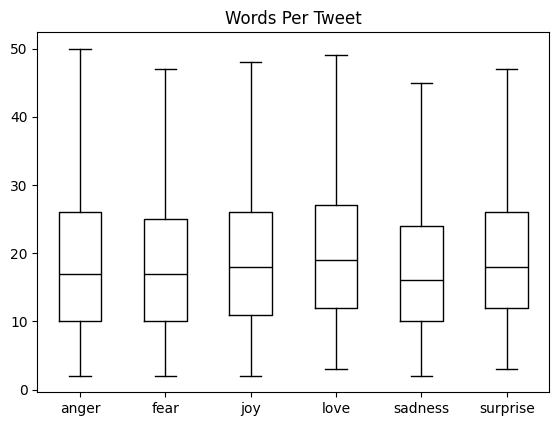

In [14]:
 df["Words Per Tweet"] = df["text"].str.split().apply(len)

 df.boxplot("Words Per Tweet", by="label_name", grid=False,
 showfliers=False, color="black")

 plt.suptitle("")
 plt.xlabel("")
 plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long
 and the longest tweets are well below DistilBERT’s maximum context size. Texts that
 are longer than a model’s context size need to be truncated, which can lead to a loss in
 performance if the truncated text contains crucial information; in this case, it looks
 like that won’t be an issue.


  Let’s now figure out how we can convert these raw texts into a format suitable for 
 Transformers! While we’re at it, let’s also reset the output format of our dataset
 since we don’t need the DataFrame format anymore

In [15]:
 emotions.reset_format()


# From Text to Tokens


Transformer models like DistilBERT cannot receive raw strings as input; instead, they
 assume the text has been tokenized and encoded as numerical vectors. Tokenization is
 the step of breaking down a string into the atomic units used in the model. There are
 several tokenization strategies one can adopt, and the optimal splitting of words into
 subunits is usually learned from the corpus. Before looking at the tokenizer used for
 DistilBERT, let’s consider two extreme cases: character and word tokenization.

## Vetores One-Hot para Identificação de Tokens

Os vetores one-hot são uma técnica comum utilizada em processamento de linguagem natural (NLP) para representar tokens de forma binária. Cada vetor one-hot tem uma única entrada "quente" com valor 1, enquanto todas as outras entradas são 0. Isso permite identificar de forma única cada token em um vocabulário.

Estrutura dos Vetores One-Hot
Considere um DataFrame onde cada linha representa um vetor one-hot. Cada vetor tem uma única entrada "quente" com valor 1 e 0s em todas as outras posições. Por exemplo, se tivermos um vocabulário de três tokens ["token1", "token2", "token3"], os vetores one-hot seriam:

token1: [1, 0, 0]
token2: [0, 1, 0]
token3: [0, 0, 1]

Problema com IDs Ordinais
Ao olhar para os input_ids, que são os identificadores dos tokens, enfrentamos um problema semelhante: os elementos criam uma escala ordinal. Isso significa que operações como adição ou subtração de dois IDs são sem sentido, pois o resultado é um novo ID que representa outro token aleatório. Por exemplo, se token1 tem ID 1 e token2 tem ID 2, a soma desses IDs resulta em 3, que pode representar um token completamente diferente.

Interpretação dos Vetores One-Hot
Por outro lado, a soma de dois vetores one-hot pode ser facilmente interpretada: as duas entradas "quentes" indicam que os tokens correspondentes co-ocorrem. Por exemplo, somando os vetores one-hot de token1 e token2:

[1, 0, 0] + [0, 1, 0] = [1, 1, 0]
Isso indica que token1 e token2 co-ocorrem.

# Subword Tokenization
 The basic idea behind subword tokenization is to combine the best aspects of charac
ter and word tokenization. On the one hand, we want to split rare words into smaller
 units to allow the model to deal with complex words and misspellings. On the other
 hand, we want to keep frequent words as unique entities so that we can keep the
 length of our inputs to a manageable size. The main distinguishing feature of
 subword tokenization (as well as word tokenization) is that it is learned from the pre
training corpus using a mix of statistical rules and algorithms.


There are several subword tokenization algorithms that are commonly used in NLP,
 but let’s start with WordPiece,5 which is used by the BERT and DistilBERT tokenizers.
 The easiest way to understand how WordPiece works is to see it in action.  Trans
formers provides a convenient AutoTokenizer class that allows you to quickly load
 the tokenizer associated with a pretrained model—we just call its from_pretrained()
 method, providing the ID of a model on the Hub or a local file path. Let’s start by
 loading the tokenizer for DistilBERT:

In [16]:
 from transformers import AutoTokenizer
 model_ckpt = "distilbert-base-uncased"
 tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

### The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models

 Let’s examine how this tokenizer works by feeding it our simple “Tokenizing text is a
 core task of NLP.” example text:

In [17]:
 text = "Tokenizing text is a core task of NLP."

In [18]:
 encoded_text = tokenizer(text)
 print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


 Just as with character tokenization, we can see that the words have been mapped to
 unique integers in the input_ids field. We’ll discuss the role of the attention_mask
 field in the next section. Now that we have the input_ids, we can convert them back
 into tokens by using the tokenizer’s convert_ids_to_tokens() method:

In [19]:
 tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
 print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


 We can observe three things here. First, some special [CLS] and [SEP] tokens have
 been added to the start and end of the sequence. These tokens differ from model to
 model, but their main role is to indicate the start and end of a sequence. Second, the
 tokens have each been lowercased, which is a feature of this particular checkpoint.
 Finally, we can see that “tokenizing” and “NLP” have been split into two tokens,
 which makes sense since they are not common words. The ## prefix in ##izing and
 ##p means that the preceding string is not whitespace; any token with this prefix
 should be merged with the previous token when you convert the tokens back to a
 string. The AutoTokenizer class has a convert_tokens_to_string() method for
 doing just that, so let’s apply it to our tokens:

In [20]:
 print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


# Tokenizing the Whole Dataset


In [21]:
 def tokenize(batch):
     return tokenizer(batch["text"], padding=True, truncation=True)

 This function applies the tokenizer to a batch of examples; padding=True will pad the
 examples with zeros to the size of the longest one in a batch, and truncation=True
 will truncate the examples to the model’s maximum context size. To see tokenize()
 in action, let’s pass a batch of two examples from the training set:

In [22]:
 print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


 Here we can see the result of padding: the first element of input_ids is shorter than
 the second, so zeros have been added to that element to make them the same length.
 These zeros have a corresponding [PAD] token in the vocabulary, and the set of spe
cial tokens also includes the [CLS] and [SEP] tokens that we encountered earlier:

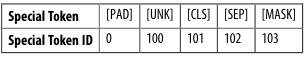

 Also note that in addition to returning the encoded tweets as input_ids, the token
izer returns a list of attention_mask arrays. This is because we do not want the
 model to get confused by the additional padding tokens: the attention mask allows
 the model to ignore the padded parts of the input. 

  Once we’ve defined a processing function, we can apply it across all the splits in the
 corpus in a single line of code

In [23]:
 emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)


 By default, the map() method operates individually on every example in the corpus,
 so setting batched=True will encode the tweets in batches. Because we’ve set
 batch_size=None, our tokenize() function will be applied on the full dataset as a
 single batch. This ensures that the input tensors and attention masks have the same
 shape globally, and we can see that this operation has added new input_ids and
 attention_mask columns to the dataset:

In [24]:
 print(emotions_encoded["train"].column_names)


['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

Passo a Passo do Processo
Tokenização e Vetores One-Hot:

Tokenização: O texto é dividido em tokens, que são as menores unidades de significado (como palavras ou subpalavras).
Vetores One-Hot: Cada token é representado como um vetor one-hot, onde apenas uma posição tem o valor 1 (indicando o token) e todas as outras posições têm o valor 0. Esses vetores são chamados de "token encodings".
Dimensão dos Vetores One-Hot: A dimensão desses vetores é determinada pelo tamanho do vocabulário do tokenizador, que geralmente varia de 20.000 a 200.000 tokens únicos.
Conversão para Embeddings:

Token Embeddings: Os vetores one-hot são convertidos em embeddings de tokens, que são vetores em um espaço de dimensão mais baixa. Isso é feito para reduzir a dimensionalidade e tornar o processamento mais eficiente.
Espaço de Dimensão Inferior: Os embeddings de tokens vivem em um espaço de dimensão inferior, o que facilita o processamento pelos modelos de linguagem.
Passagem pelos Blocos do Encoder:

Blocos do Encoder: Os embeddings de tokens são passados através das camadas do bloco do encoder. Cada camada do encoder processa os embeddings e gera um estado oculto (hidden state) para cada token de entrada.
Estado Oculto: O estado oculto é uma representação intermediária do token após ser processado pelo encoder.
Objetivo de Pré-Treinamento (Language Modeling):

Predição de Tokens Mascarados: Para o objetivo de pré-treinamento de modelagem de linguagem, cada estado oculto é alimentado em uma camada que prevê os tokens de entrada mascarados. Isso ajuda o modelo a aprender a prever palavras faltantes no texto.
Tarefa de Classificação:

Camada de Classificação: Para a tarefa de classificação, a camada de modelagem de linguagem é substituída por uma camada de classificação. Essa camada usa os estados ocultos para prever a classe do texto de entrada (por exemplo, se o texto é positivo ou negativo).


 We have two options to train such a model on our Twitter dataset:

 
 Feature extraction -
 We use the hidden states as features and just train a classifier on them, without
 modifying the pretrained model.


 Fine-tuning -
 We train the whole model end-to-end, which also updates the parameters of the
 pretrained model.

# Transformers as Feature Extractors
 Using a transformer as a feature extractor is fairly simple. As shown in Figure 2-5, we
 freeze the body’s weights during training and use the hidden states as features for the
 classifier. The advantage of this approach is that we can quickly train a small or shal
low model. Such a model could be a neural classification layer or a method that does
 not rely on gradients, such as a random forest. This method is especially convenient if
 GPUs are unavailable, since the hidden states only need to be precomputed once.

 ### We will use another convenient auto class from  Transformers called AutoModel. Similar to the AutoTokenizer class, AutoModel has a from_pretrained() method to load the weights of a pretrained model. Let’s use this method to load the DistilBERT checkpoint:

In [25]:
 from transformers import AutoModel
 import torch


 model_ckpt = "distilbert-base-uncased"
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 model = AutoModel.from_pretrained(model_ckpt).to(device)

 The AutoModel class converts the token encodings to embeddings, and then feeds
 them through the encoder stack to return the hidden states. Let’s take a look at how
 we can extract these states from our corpus.

###  Extracting the last hidden states

 To warm up, let’s retrieve the last hidden states for a single string. The first thing we
 need to do is encode the string and convert the tokens to PyTorch tensors. This can
 be done by providing the return_tensors="pt" argument to the tokenizer as follows

 Os estados ocultos em modelos como RNNs têm uma característica que pode ser comparada à recursão, mas não são exatamente a mesma coisa.

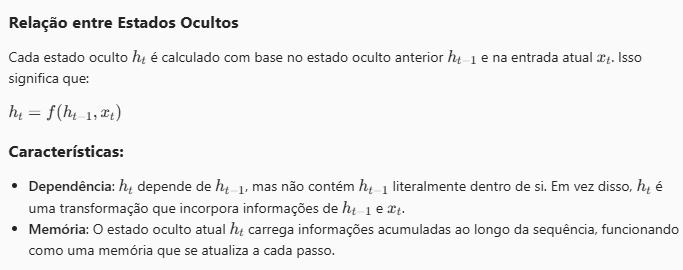

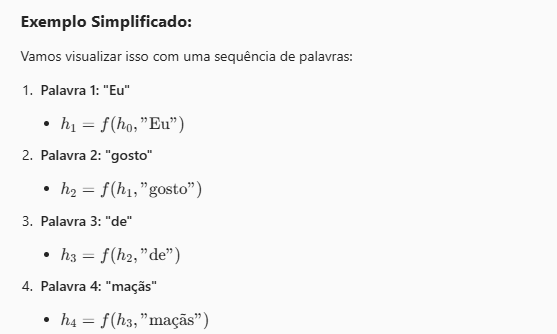

In [26]:
 text = "this is a test"
 inputs = tokenizer(text, return_tensors="pt")
 print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


As we can see, the resulting tensor has the shape [batch_size, n_tokens]. Now that
 we have the encodings as a tensor, the final step is to place them on the same device
 as the model and pass the inputs as follows

### last hidden state

É um tensor de 3 dimensões (batch_size, sequence_length, hidden_size). Cada vetor dentro do tensor representa a saída do modelo para cada token na sequência de entrada. Esses vetores contêm informações contextuais que o modelo aprendeu sobre cada token.

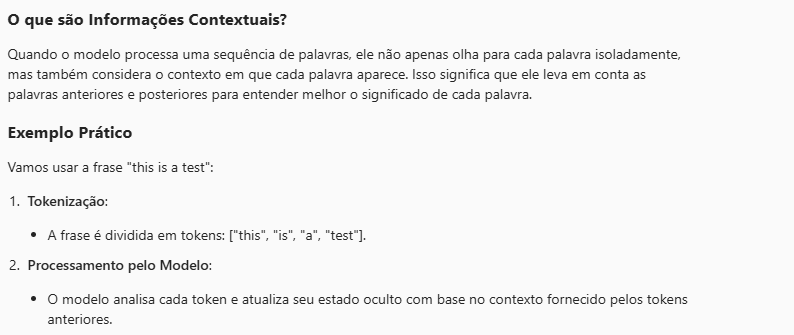

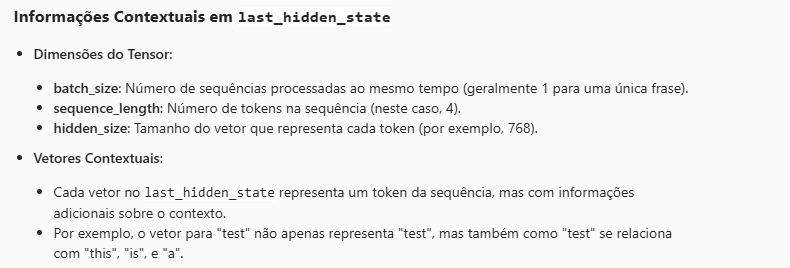

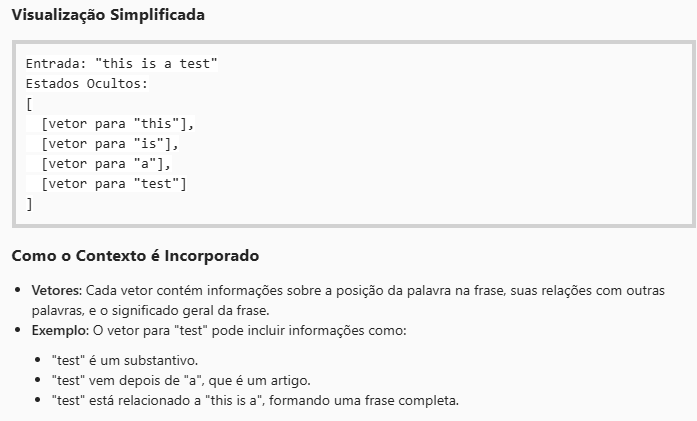


In [27]:
 inputs = {k:v.to(device) for k,v in inputs.items()}
 with torch.no_grad():
     outputs = model(**inputs)
 print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


Here we’ve used the torch.no_grad() context manager to disable the automatic cal
culation of the gradient. This is useful for inference since it reduces the memory foot
print of the computations. Depending on the model configuration, the output can
 contain several objects, such as the hidden states, losses, or attentions, arranged in a
 class similar to a namedtuple in Python. In our example, the model output is an
 instance of BaseModelOutput, and we can simply access its attributes by name. The
 current model returns only one attribute, which is the last hidden state, so let’s exam
ine its shape

In [28]:
 outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

 Looking at the hidden state tensor, we see that it has the shape [batch_size,
 n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
 each of the 6 input tokens. For classification tasks, it is common practice to just use
 the hidden state associated with the [CLS] token as the input feature. Since this token
 appears at the start of each sequence, we can extract it by simply indexing into
 outputs.last_hidden_state as follows

In [29]:
 outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

 Now we know how to get the last hidden state for a single string; let’s do the same for
 the whole dataset by creating a new hidden_state column that stores all these vec
tors. As we did with the tokenizer, we’ll use the map() method of DatasetDict to
 extract all the hidden states in one go. The first thing we need to do is wrap the previ
ous steps in a processing function:

In [30]:
 def extract_hidden_states(batch):
     # Place model inputs on the GPU
     inputs = {k:v.to(device) for k,v in batch.items()
               if k in tokenizer.model_input_names}
     # Extract last hidden states
     with torch.no_grad():
         last_hidden_state = model(**inputs).last_hidden_state
     # Return vector for [CLS] token
     return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

 The only difference between this function and our previous logic is the final step
 where we place the final hidden state back on the CPU as a NumPy array. The map()
 method requires the processing function to return Python or NumPy objects when
 we’re using batched inputs

  Since our model expects tensors as inputs, the next thing to do is convert the
 input_ids and attention_mask columns to the "torch" format, as follows:

In [31]:
 emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])

 We can then go ahead and extract the hidden states across all splits in one go:


In [32]:
 emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)


 Notice that we did not set batch_size=None in this case, which means the default
 batch_size=1000 is used instead. 

Batch size é um parâmetro importante em aprendizado de máquina e processamento 
de dados que define o número de amostras que serão processadas juntas em uma 
única iteração. Aqui está uma explicação detalhada:

O que é Batch Size?
Definição: Batch size é o número de amostras de dados que o modelo 
processa antes de atualizar seus parâmetros. Em outras palavras, é o número 
de exemplos que são passados pelo modelo em uma única vez durante o 
treinamento ou inferência.

Impacto: O tamanho do batch pode afetar a eficiência do treinamento e a qualidade do modelo. Batches menores podem levar a atualizações mais frequentes dos parâmetros, enquanto batches maiores podem aproveitar melhor a paralelização e a eficiência computacional.

Exemplos de Batch Size

Batch Size Pequeno: Se o batch size for 32, o modelo processará 32 amostras de dados antes de atualizar seus parâmetros.

Batch Size Grande: Se o batch size for 128, o modelo processará 128 amostras de dados antes de atualizar seus parâmetros.

O que acontece se não setar o Batch Size?

Valor Padrão: Se você não definir o batch size (batch_size=None), a função map usará um valor padrão. Esse valor padrão pode variar dependendo da implementação da função e do framework que você está usando.

Processamento: Sem um batch size definido, o processamento pode ser feito em um único batch contendo todas as amostras, o que pode ser ineficiente e consumir muita memória, especialmente para grandes conjuntos de dados.

 ### Exemplo
### Suponha que você tenha um conjunto de dados com 1.000 amostras e defina um batch size de 100. O treinamento será dividido em 10 batches, e o modelo processará 100 amostras de cada vez antes de atualizar seus parâmetros. Isso significa que o modelo fará 10 atualizações de parâmetros por época (uma passagem completa por todos os dados).
     
 As expected, applying the extract_ hidden_
 states() function has added a new hidden_state column to our dataset:

In [33]:
 emotions_hidden["train"].column_names


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#  Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. 

In [34]:
 import numpy as np
 X_train = np.array(emotions_hidden["train"]["hidden_state"])
 X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
 y_train = np.array(emotions_hidden["train"]["label"])
 y_valid = np.array(emotions_hidden["validation"]["label"])
 X_train.shape, X_valid.shape

C:\Users\anali\AppData\Local\Temp\ipykernel_20940\1516450754.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array(emotions_hidden["train"]["hidden_state"])
C:\Users\anali\AppData\Local\Temp\ipykernel_20940\1516450754.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
C:\Users\anali\AppData\Local\Temp\ipykernel_20940\1516450754.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(emotions_hidden["train"]["label"])
C:\Users\anali\AppData\Local\Temp\ipykernel_20940\1516450754.py:5: DeprecationWarning: __array__ implemen

((16000, 768), (2000, 768))

#  Visualizing the training set in 2 dimensions only

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we’ll
 use the powerful UMAP algorithm to project the vectors down to 2D.7 Since UMAP
 works best when the features are scaled to lie in the [0,1] interval, we’ll first apply a
 MinMaxScaler and then use the UMAP implementation from the umap-learn library
 to reduce the hidden states

In [35]:
# !pip install umap-learn


In [36]:
 from umap import UMAP
 from sklearn.preprocessing import MinMaxScaler

 # Scale features to [0,1] range
 X_scaled = MinMaxScaler().fit_transform(X_train)

 # Initialize and fit UMAP
 mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

 # Create a DataFrame of 2D embeddings
 df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
 df_emb["label"] = y_train
 df_emb.head()

C:\Users\anali\miniconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.276227,2.681694,0
1,-2.984182,3.269584,0
2,5.057319,6.113655,3
3,-2.506494,5.601338,2
4,-3.446820,5.270237,3


 The result is an array with the same number of training samples, but with only 2 fea
tures instead of the 768 we started with!

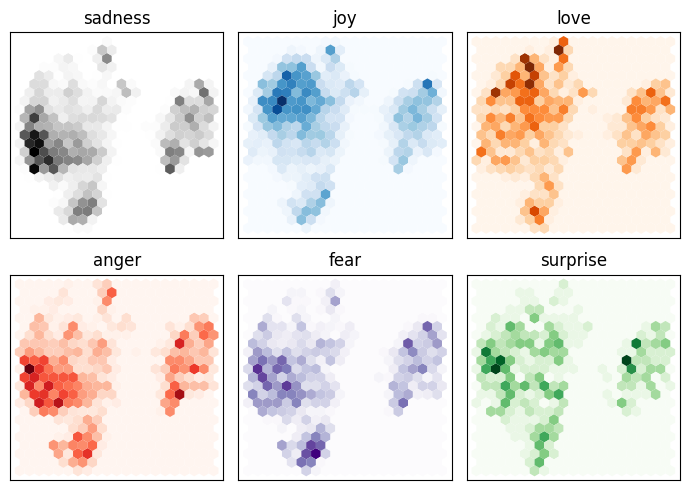

In [37]:
 fig, axes = plt.subplots(2, 3, figsize=(7,5))
 axes = axes.flatten()
 cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
 labels = emotions["train"].features["label"].names
 for i, (label, cmap) in enumerate(zip(labels, cmaps)):
     df_emb_sub = df_emb.query(f"label == {i}")
     axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
         gridsize=20, linewidths=(0,))
     axes[i].set_title(label)
     axes[i].set_xticks([]), axes[i].set_yticks([])

 plt.tight_layout()
 plt.show()

Acima podemos ver um gráfico de densidade de pontos, é notável que as emoções negativas ocupam regiões similares.

Enquando alegria e amor estão bem separadas das emoções negativas e compartilham um espaço em comum.

Já a surpresa está mais espalhada.

#### Estas são apenas projeções em um espaço de menor dimensão. Só porque algumas categorias se sobrepõem não significa que elas não sejam separáveis no espaço original. Por outro lado, se elas são separáveis no espaço projetado, elas serão separáveis no espaço original



# Treinando um classificador simples de regressão logística

In [38]:
 from sklearn.linear_model import LogisticRegression
 # We increase `max_iter` to guarantee convergence
 lr_clf = LogisticRegression(max_iter=3000)
 lr_clf.fit(X_train, y_train)
 lr_clf.score(X_valid, y_valid)

0.6345

acima temos uma acurácia de 63%, pode parecer pouco, mas dado que nossos dados também estavam desbalanceados, podemos considerar ok. 

Vamos fazer testes com um DummyClassifier, que faz classificações aleatórias, assim podemos comparar os resultados.

No nosso caso, a maior performance seria sempre escolher a classe mais frequente, o que nos dá uma acorácia de 35%

In [39]:
 from sklearn.dummy import DummyClassifier
 dummy_clf = DummyClassifier(strategy="most_frequent")
 dummy_clf.fit(X_train, y_train)
 dummy_clf.score(X_valid, y_valid)

0.352

 So, our simple classifier with DistilBERT embeddings is significantly better than our
 baseline. We can further investigate the performance of the model by looking at the
 confusion matrix of the classifier, which tells us the relationship between the true and
 predicted labels

# Matriz de confusão

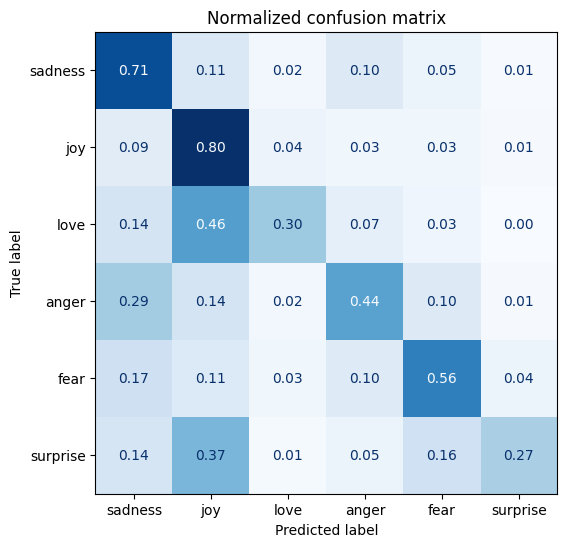

In [40]:
 from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

 def plot_confusion_matrix(y_preds, y_true, labels):
     cm = confusion_matrix(y_true, y_preds, normalize="true")
     fig, ax = plt.subplots(figsize=(6, 6))
     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
     disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
     plt.title("Normalized confusion matrix")
     plt.show()
     
 y_preds = lr_clf.predict(X_valid)
 plot_confusion_matrix(y_preds, y_valid, labels)

Podemos ver que love foi bastante confundido com joy. -> ocupavam espaços semelhantes na densidade de pontos

anger foi confundido com sadness. -> dois sentimentos negativos com espaços semelhantes. 

fear com sadness. -> dois sentimentos negativos com espaços semelhantes. 

E surprise teve a pior classificação, sendo muito confundido com joy. -> surprise estava bastante espalhado pelo espaço.


#  Fine-Tuning Transformers

When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head

 Training the hidden states that serve as inputs to the classification model will help us
 avoid the problem of working with data that may not be well suited for the classifica
tion task. Instead, the initial hidden states adapt during training to decrease the
 model loss and thus increase its performance.

##  Loading a pretrained model

 The first thing we need is a pretrained DistilBERT model like the one we used in the
 feature-based approach. The only slight modification is that we use the AutoModelFor
 SequenceClassification model instead of AutoModel. The difference is that the
 AutoModelForSequenceClassification model has a classification head on top of the
 pretrained model outputs, which can be easily trained with the base model. We just
 need to specify how many labels the model has to predict (six in our case), since this
 dictates the number of outputs the classification head has

In [41]:
 from transformers import AutoModelForSequenceClassification

 num_labels = 6
 model = (AutoModelForSequenceClassification
     .from_pretrained(model_ckpt, num_labels=num_labels)
     .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining the performance metrics

 To monitor metrics during training, we need to define a compute_metrics() function
 for the Trainer. This function receives an EvalPrediction object (which is a named
 tuple with predictions and label_ids attributes) and needs to return a dictionary
 that maps each metric’s name to its value. For our application, we’ll compute the
 F1-score and the accuracy of the model as follows

In [42]:
 from sklearn.metrics import accuracy_score, f1_score

 def compute_metrics(pred):
     labels = pred.label_ids
     preds = pred.predictions.argmax(-1)
     f1 = f1_score(labels, preds, average="weighted")
     acc = accuracy_score(labels, preds)
     return {"accuracy": acc, "f1": f1}

In [43]:
# !pip install huggingface_hub

In [44]:
from huggingface_hub import notebook_login

notebook_login()

In [45]:
# !pip install accelerate>=0.26.0
# !pip install --upgrade tensorflow
# !pip install --upgrade tf_keras


In [46]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
     num_train_epochs=2,
     learning_rate=2e-5,
     per_device_train_batch_size=batch_size,
     per_device_eval_batch_size=batch_size,
     weight_decay=0.01,
     eval_strategy="epoch",
     disable_tqdm=False,
     logging_steps=logging_steps,
     push_to_hub=True,
     log_level="error")

In [48]:
 from transformers import Trainer

 trainer = Trainer(model=model, args=training_args,
     compute_metrics=compute_metrics,
     train_dataset=emotions_encoded["train"],
     eval_dataset=emotions_encoded["validation"],
     tokenizer=tokenizer)
 trainer.train();

C:\Users\anali\AppData\Local\Temp\ipykernel_20940\3415268046.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.804500,0.303091,0.912500,0.912207
2,0.241500,0.213537,0.924000,0.924032


Pelos logs, podemos ver que o modelo tem um f1-score de cerca de 92%; bem melhor que o primeiro método testado.

Vamos visualizar melhor pela matriz de confusão, para isso, obtenhamos as predições para o conjunto de validação

In [49]:
 preds_output = trainer.predict(emotions_encoded["validation"])


In [50]:
 preds_output.metrics


{'test_loss': 0.2135372906923294,
 'test_accuracy': 0.924,
 'test_f1': 0.9240320577006542,
 'test_runtime': 98.9914,
 'test_samples_per_second': 20.204,
 'test_steps_per_second': 0.323}

Acima, o que vemos são as métricas gerais, mas este objeto também contém as predições para cada classe, e podemos decodificar as predições de maneira gulosa usando np.argmax(); isso gera os rótulos previstos e tem o mesmo formato que os rótulos retornados pelos modelos do scikit learn

In [51]:
 y_preds = np.argmax(preds_output.predictions, axis=1)


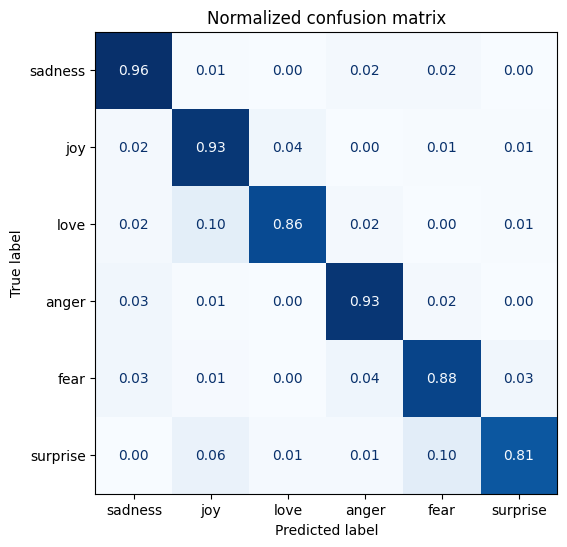

In [52]:
 plot_confusion_matrix(y_preds, y_valid, labels)


# Análise de erro

In [53]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Coloca todos os tensores de entrada no mesmo dispositivo que o modelo
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    # Desativa o cálculo de gradientes para economizar memória e acelerar a execução
    with torch.no_grad():
        # Executa o modelo com as entradas fornecidas
        output = model(**inputs)
        
        # Calcula o rótulo previsto usando a função argmax nos logits de saída
        pred_label = torch.argmax(output.logits, axis=-1)
        
        # Calcula a perda de entropia cruzada entre os logits de saída e os rótulos reais
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
        
        # Coloca as saídas na CPU para compatibilidade com outras colunas do conjunto de dados
        return {"loss": loss.cpu().numpy(),
                "predicted_label": pred_label.cpu().numpy()}

Os logits de saída são os valores brutos produzidos pela última camada de um modelo de rede neural antes de aplicar uma função de ativação, como a softmax. Eles representam as pontuações não normalizadas para cada classe em uma tarefa de classificação.

Detalhamento
Valores Brutos: Os logits são os valores diretos calculados pelo modelo, sem nenhuma transformação para torná-los probabilidades.


Última Camada: Eles vêm da última camada do modelo, que geralmente é uma camada totalmente conectada (dense layer).


Antes da Softmax: Em tarefas de classificação, a função softmax é aplicada aos logits para convertê-los em probabilidades, que somam 1 e podem ser interpretadas como a confiança do modelo em cada classe.

usando o map() novamente, conseguitemos aplicar a função acima para obter as perdas de todas as amostras

In [54]:
 # Convert our dataset back to PyTorch tensors
 emotions_encoded.set_format("torch",
     columns=["input_ids", "attention_mask", "label"])
 # Compute loss values
 emotions_encoded["validation"] = emotions_encoded["validation"].map(
     forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Criando o df com textos, perdas e labels preditas vs. as reais

In [55]:
# Define o formato do conjunto de dados emotions_encoded como um DataFrame do pandas
emotions_encoded.set_format("pandas")

# Especifica as colunas que serão selecionadas
cols = ["text", "label", "predicted_label", "loss"]

# Seleciona as colunas especificadas do conjunto de dados de validação
df_test = emotions_encoded["validation"][:][cols]

# Converte os valores da coluna "label" de inteiros para strings usando a função label_int2str
df_test["label"] = df_test["label"].apply(label_int2str)

# Converte os valores da coluna "predicted_label" de inteiros para strings usando a função label_int2str
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

Vamos verificar as amostras com as maiores perdas

In [56]:
 df_test.sort_values("loss", ascending=False).head(10)


,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.302451
1963,i called myself pro life and voted for perry w...,joy,sadness,5.258901
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.175935
882,i feel badly about reneging on my commitment t...,love,sadness,5.108697
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.029902
1274,i am going to several holiday parties and i ca...,joy,sadness,4.897841
465,i would eventually go in to these stores but i...,joy,fear,4.872615
1950,i as representative of everything thats wrong ...,surprise,anger,4.837160
1509,i guess this is a memoir so it feels like that...,joy,fear,4.749271
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.727417


pode ocorrer de alguns terem sido rotulados de maneira errada, como podemos notar pelos tweets que talvez tenham ambiguidade ou realmente tenham sido totalmente marcados incorretamente.

agora as amostras com as menores perdas

In [58]:
 df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.016474
1090,i dont know what it is about me and sweets the...,joy,joy,0.016560
131,i feel like a graph doesnt show the data accur...,joy,joy,0.016793
1263,i feel this way about blake lively,joy,joy,0.017079
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017244
620,i shall move right along to the post interview...,joy,joy,0.017325
1873,i feel practically virtuous this month i have ...,joy,joy,0.017378
1544,i feel that my charlie card is much more valua...,joy,joy,0.017471
578,i got to christmas feeling positive about the ...,joy,joy,0.017476
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017548


o modelo está mais confiante em classificar joy.

#### com essas informações, será possível realizar melhoras de classificação no nosso dataset!